# Grad-cam_ImageDataGenerator

Show the heatmap for test data(multiple images). 

Read images method: ImageDataGenerator()

https://colab.research.google.com/github/Engineer1999/Chest-X-ray-classification-with-GradCAM/blob/main/Chest_X_ray_classification_using_Transfer_Learning_and_GradCAM_for_transparency.ipynb#scrollTo=snc0-2dk0q-d


In [1]:
import numpy as np
from random import shuffle
from miscellaneous import read_config
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from collections import Counter
import os


## Parse configuration file + initializations

In [2]:
# read config files
main_path = os.path.abspath(os.path.dirname(os.getcwd()))
config_path= os.path.join(main_path,'config.yaml')
cfg = read_config(config_path)

# constants
image_height = cfg['image_height']
image_width = cfg['image_width']
batch_size = cfg['batch_size']['tst'] 

# paths
path_test = cfg['Path']['path_test']
# path_test = r'F:\Tianlong\Data\Deep_Plastic\Data\Exp1\1'



In [3]:
path_test

'F:\\Tianlong\\Data\\Deep_Plastic\\Data\\Exp1\\Test 1'

## Load test data

In [4]:
# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://medium.com/analytics-vidhya/data-augmentation-is-it-really-necessary-b3cb12ab3c3f


test_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator()

testing_set = test_datagen.flow_from_directory(path_test,
                                               target_size=(image_height, image_width),
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               seed=None,
                                               shuffle=True)


Found 403 images belonging to 4 classes.


In [18]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
print("test batch size: ", testing_set.__getitem__(0)[0].shape)
print("Five sample test labels in the first batch\n", testing_set.__getitem__(0)[1][:5])
print("class_indices: ",testing_set.class_indices)

test batch size:  (16, 224, 224, 3)
Five sample test labels in the first batch
 [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
class_indices:  {'0 - No Plastic': 0, '1 - Little Plastic': 1, '2 - Moderate Plastic': 2, '3 - Lot Plastic': 3}


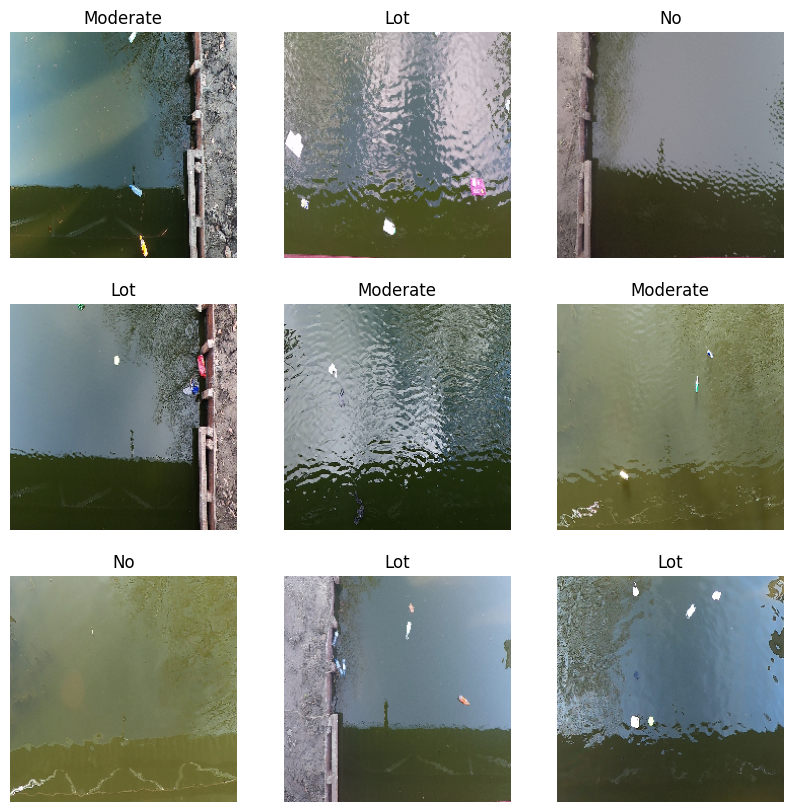

In [19]:
labels = ['No', 'Little', 'Moderate', 'Lot']

# capture the first batch and show images
# Here batch_size should be over 9, otherwise it will report an error 
sample_data = testing_set.__getitem__(0)[0]
sample_label = testing_set.__getitem__(0)[1]

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i]) # the "i" image in the first batch
    plt.title(labels[np.argmax(sample_label[i])])


## Load Gradcam method

In [7]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()


In [8]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # jet = cm.get_cmap("viridis")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_height, image_width))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


## Model loading

In [9]:
# load MobileNet
model_path = r"F:\Tianlong\PythonProject\deep_plastic\output\TL_vs_scratch\model_trained_for_GradCam\weights\mobile_net_lr_0.0001_TL_all_GC.hdf5"

# load SqueezeNet
# model_path = r"F:\Tianlong\PythonProject\deep_plastic\output\TL_vs_scratch\from_scratch_weights\squeeze_net_lr_0.00001.hdf5"

model = tf.keras.models.load_model(model_path)
# model.summary()


In [10]:
# Predict the one sample in test data

out_put = model.predict(np.expand_dims(sample_data[0], axis=0))
print ("predicted: ", labels[np.argmax(out_put)])
print ("True label: ", sample_label[0])


predicted:  Lot
True label:  [0. 0. 0. 1.]


## Define model layer for gradcam

In [11]:
# MoblieNet
last_conv_layer_name = "Conv_1"
classifier_layer_names = [
    "global_average_pooling2d",
    "dense"
]

# # Squeeze
# last_conv_layer_name = "conv10"
# classifier_layer_names = [
#     "global_average_pooling2d",
#     "dense"
# ]


## Show the heat-map of images

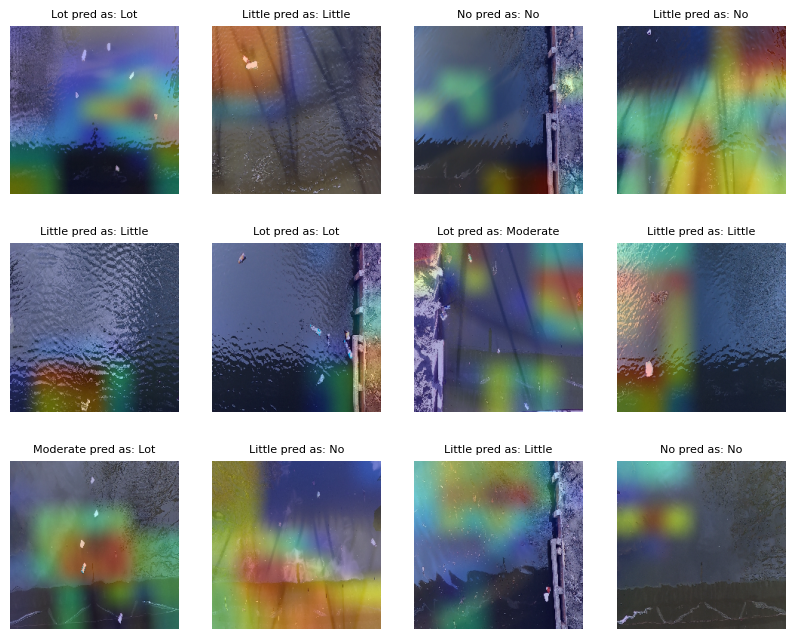

In [12]:
# capture the first batch and show images
# Here batch_size should be over 12, otherwise it will report an error 

plt.figure(figsize=(10, 8))
k = 2
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(
        sample_data[k], axis=0), model, last_conv_layer_name, classifier_layer_names)
    # print(heatmap.shape)
    img = np.uint8(255 * sample_data[k])
    img = superimposed_img(img, heatmap)

    plt.imshow(img)
    plt.title(labels[np.argmax(sample_label[k])] +
              " pred as: " + labels[top_index], fontsize=8)
    k = k+1
